Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [12]:
pickle_file = './notmnist_data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [13]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [14]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [15]:
# Logistic regression with SGD
batch_size = 128
beta = 0.002

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)
    

# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 25.166777
Minibatch accuracy: 12.5%
Validation accuracy: 13.3%
Minibatch loss at step 500: 2.724905
Minibatch accuracy: 78.1%
Validation accuracy: 76.9%
Minibatch loss at step 1000: 1.410637
Minibatch accuracy: 81.2%
Validation accuracy: 79.9%
Minibatch loss at step 1500: 0.708449
Minibatch accuracy: 85.2%
Validation accuracy: 81.2%
Minibatch loss at step 2000: 0.675970
Minibatch accuracy: 87.5%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 0.660748
Minibatch accuracy: 81.2%
Validation accuracy: 81.6%
Minibatch loss at step 3000: 0.793425
Minibatch accuracy: 81.2%
Validation accuracy: 82.0%
Test accuracy: 89.2%


In [16]:
# NN model with SGD
batch_size = 128
hidden1_units = 1024
beta = 0.0015

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units]))
  biases = tf.Variable(tf.zeros([hidden1_units]))

  # One hidden layer
  hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights) + biases)

  # Linear weights multiply and add biases to produce output y logits with 10 classes
  weights_logits = tf.Variable(tf.truncated_normal([hidden1_units, num_labels]))
  biases_logits = tf.Variable(tf.zeros([num_labels]))
  
  logits = tf.matmul(hidden1, weights_logits) + biases_logits

  # flatten weight matrices and concatenate into a vector
  weights_flat = tf.reshape(weights, [-1])
  weights2_flat = tf.reshape(weights_logits, [-1]) 

  # Note that tf.concat takes parameters (axis, values) instead of (values, axis) as per TF guide
  weights_l2 = tf.concat(0, [weights_flat, weights2_flat])

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights_l2)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
      tf.matmul(tf_valid_dataset, weights) + biases), weights_logits) + biases_logits)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(
      tf.matmul(tf_test_dataset, weights) + biases), weights_logits) + biases_logits)
    
# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 900.551147
Minibatch accuracy: 11.7%
Validation accuracy: 40.8%
Minibatch loss at step 500: 225.412842
Minibatch accuracy: 85.2%
Validation accuracy: 80.7%
Minibatch loss at step 1000: 104.038940
Minibatch accuracy: 82.0%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 48.494278
Minibatch accuracy: 90.6%
Validation accuracy: 84.6%
Minibatch loss at step 2000: 23.029921
Minibatch accuracy: 91.4%
Validation accuracy: 86.1%
Minibatch loss at step 2500: 11.095854
Minibatch accuracy: 92.2%
Validation accuracy: 86.4%
Minibatch loss at step 3000: 5.695578
Minibatch accuracy: 85.2%
Validation accuracy: 86.8%
Test accuracy: 93.3%


In [18]:
# NN model with SGD
batch_size = 128
hidden1_units = 1024
beta = 0.0015

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units]))
  layer1_biases = tf.Variable(tf.zeros([hidden1_units]))

  # Linear weights multiply and add biases to produce output y logits with 10 classes
  layer2_weights = tf.Variable(tf.truncated_normal([hidden1_units, num_labels]))
  layer2_biases = tf.Variable(tf.zeros([num_labels]))

  # Model with one hidden layer
  def model(data):
    hidden = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
    return tf.matmul(hidden, layer2_weights) + layer2_biases    
  
  logits = model(tf_train_dataset)

  # flatten weight matrices and concatenate into a vector
  weights_flat = tf.reshape(layer1_weights, [-1])
  weights2_flat = tf.reshape(layer2_weights, [-1]) 

  # Note that tf.concat takes parameters (axis, values) instead of (values, axis) as per TF guide
  weights_l2 = tf.concat(0, [weights_flat, weights2_flat])

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights_l2)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 807.521362
Minibatch accuracy: 5.5%
Validation accuracy: 29.3%
Minibatch loss at step 500: 227.178177
Minibatch accuracy: 83.6%
Validation accuracy: 80.2%
Minibatch loss at step 1000: 104.344170
Minibatch accuracy: 81.2%
Validation accuracy: 81.6%
Minibatch loss at step 1500: 48.497299
Minibatch accuracy: 89.1%
Validation accuracy: 84.1%
Minibatch loss at step 2000: 23.011213
Minibatch accuracy: 93.0%
Validation accuracy: 86.0%
Minibatch loss at step 2500: 11.134644
Minibatch accuracy: 86.7%
Validation accuracy: 86.5%
Minibatch loss at step 3000: 5.651641
Minibatch accuracy: 82.8%
Validation accuracy: 86.9%
Test accuracy: 93.4%


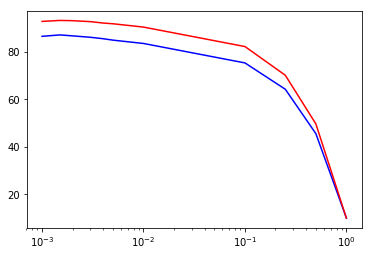

In [19]:
# Plot validation and test scores for different beta value tests
beta = [0.001, 0.0015, 0.002, 0.003, 0.004, 0.005, 0.01, 0.1, 0.25, 0.5, 1]
val = [86.6, 87.2, 86.8, 86.2, 85.6, 85, 83.6, 75.4, 64.3, 45.6, 10.0]
test = [92.9, 93.3, 93.2, 92.8, 92.2, 91.9, 90.5, 82.3, 70.2, 49.7, 10.0]
plt.plot(beta, val, 'b')
plt.plot(beta, test, 'r')
plt.xscale('log')
plt.show()

The best value of regulatization parameter beta that maximizes validation and test scores is 0.0015.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [21]:
train_subset = 1000
train_dataset_subset = train_dataset[:train_subset, :]
train_labels_subset = train_labels[:train_subset]

batch_size = 128
hidden1_units = 1024
beta = 0.0015

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units]))
  layer1_biases = tf.Variable(tf.zeros([hidden1_units]))

  # Linear weights multiply and add biases to produce output y logits with 10 classes
  layer2_weights = tf.Variable(tf.truncated_normal([hidden1_units, num_labels]))
  layer2_biases = tf.Variable(tf.zeros([num_labels]))

  # Model with one hidden layer
  def model(data):
    hidden = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
    return tf.matmul(hidden, layer2_weights) + layer2_biases    
  
  logits = model(tf_train_dataset)

  # flatten weight matrices and concatenate into a vector
  weights_flat = tf.reshape(layer1_weights, [-1])
  weights2_flat = tf.reshape(layer2_weights, [-1]) 
    
  # Note that tf.concat takes parameters (axis, values) instead of (values, axis) as per TF guide
  weights_l2 = tf.concat(0, [weights_flat, weights2_flat])

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights_l2)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels_subset.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset_subset[offset:(offset + batch_size), :]
    batch_labels = train_labels_subset[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 796.027039
Minibatch accuracy: 12.5%
Validation accuracy: 27.0%
Minibatch loss at step 500: 222.365601
Minibatch accuracy: 100.0%
Validation accuracy: 76.5%
Minibatch loss at step 1000: 105.008560
Minibatch accuracy: 100.0%
Validation accuracy: 76.6%
Minibatch loss at step 1500: 49.588764
Minibatch accuracy: 100.0%
Validation accuracy: 76.6%
Minibatch loss at step 2000: 23.419342
Minibatch accuracy: 100.0%
Validation accuracy: 76.8%
Minibatch loss at step 2500: 11.075812
Minibatch accuracy: 100.0%
Validation accuracy: 77.7%
Minibatch loss at step 3000: 5.255680
Minibatch accuracy: 100.0%
Validation accuracy: 79.1%
Test accuracy: 87.0%


The model trains on small amount of data and results in overfitting as seen by 100% accuracy for each minibatch while validation score is 79.1% and test score is 87.0%.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [26]:
# NN model with SGD
batch_size = 128
hidden1_units = 1024
beta = 0.0015

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units]))
  layer1_biases = tf.Variable(tf.zeros([hidden1_units]))

  # Linear weights multiply and add biases to produce output y logits with 10 classes
  layer2_weights = tf.Variable(tf.truncated_normal([hidden1_units, num_labels]))
  layer2_biases = tf.Variable(tf.zeros([num_labels]))
    
  keep_prob = tf.placeholder(tf.float32)

  # Model with one hidden layer and dropout
  def model(data):
    hidden = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
    hidden_drop = tf.nn.dropout(hidden, keep_prob)
    return tf.matmul(hidden_drop, layer2_weights) + layer2_biases  
  
  logits = model(tf_train_dataset)

  # flatten weight matrices and concatenate into a vector
  weights_flat = tf.reshape(layer1_weights, [-1])
  weights2_flat = tf.reshape(layer2_weights, [-1]) 

  # Note that tf.concat takes parameters (axis, values) instead of (values, axis) as per TF guide
  weights_l2 = tf.concat(0, [weights_flat, weights2_flat])

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights_l2)
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()

  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction.eval(
          feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 1.0}), batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(feed_dict={keep_prob:1.0}), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict={keep_prob:1.0}), test_labels))

Initialized
Minibatch loss at step 0: 930.646912
Minibatch accuracy: 39.1%
Validation accuracy: 28.7%
Minibatch loss at step 500: 232.410767
Minibatch accuracy: 92.2%
Validation accuracy: 80.7%
Minibatch loss at step 1000: 105.417267
Minibatch accuracy: 82.8%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 48.724182
Minibatch accuracy: 93.8%
Validation accuracy: 82.5%
Minibatch loss at step 2000: 23.132469
Minibatch accuracy: 91.4%
Validation accuracy: 84.8%
Minibatch loss at step 2500: 11.101659
Minibatch accuracy: 92.2%
Validation accuracy: 85.0%
Minibatch loss at step 3000: 5.719735
Minibatch accuracy: 86.7%
Validation accuracy: 85.6%
Test accuracy: 92.4%


Dropout of 0.5 does not improve the validation and test accuracy scores. Without the dropout, validation score is 87.0% and test score is 93.2%; with dropout, validation score is 85.6% and test accuracy is 92.4%.

In [27]:
# Test overfitting case
train_subset = 1000
train_dataset_subset = train_dataset[:train_subset, :]
train_labels_subset = train_labels[:train_subset]

batch_size = 128
hidden1_units = 1024
beta = 0.0015

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units]))
  layer1_biases = tf.Variable(tf.zeros([hidden1_units]))

  # Linear weights multiply and add biases to produce output y logits with 10 classes
  layer2_weights = tf.Variable(tf.truncated_normal([hidden1_units, num_labels]))
  layer2_biases = tf.Variable(tf.zeros([num_labels]))
    
  keep_prob = tf.placeholder(tf.float32)

  # Model with one hidden layer and dropout
  def model(data):
    hidden = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
    hidden_drop = tf.nn.dropout(hidden, keep_prob)
    return tf.matmul(hidden_drop, layer2_weights) + layer2_biases  
  
  logits = model(tf_train_dataset)

  # flatten weight matrices and concatenate into a vector
  weights_flat = tf.reshape(layer1_weights, [-1])
  weights2_flat = tf.reshape(layer2_weights, [-1]) 

  # Note that tf.concat takes parameters (axis, values) instead of (values, axis) as per TF guide
  weights_l2 = tf.concat(0, [weights_flat, weights2_flat])
    
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights_l2)

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels_subset.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset_subset[offset:(offset + batch_size), :]
    batch_labels = train_labels_subset[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction.eval(
          feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 1.0}), batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(feed_dict={keep_prob:1.0}), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict={keep_prob:1.0}), test_labels))

Initialized
Minibatch loss at step 0: 914.126709
Minibatch accuracy: 53.1%
Validation accuracy: 38.6%
Minibatch loss at step 500: 224.321732
Minibatch accuracy: 100.0%
Validation accuracy: 79.2%
Minibatch loss at step 1000: 106.167488
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Minibatch loss at step 1500: 50.085022
Minibatch accuracy: 100.0%
Validation accuracy: 79.7%
Minibatch loss at step 2000: 23.658884
Minibatch accuracy: 100.0%
Validation accuracy: 79.9%
Minibatch loss at step 2500: 11.184355
Minibatch accuracy: 100.0%
Validation accuracy: 79.9%
Minibatch loss at step 3000: 5.300735
Minibatch accuracy: 100.0%
Validation accuracy: 80.2%
Test accuracy: 87.7%


Even with the dropout, we still overfit the data after step 500.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [31]:
# NN model with SGD
batch_size = 128
hidden1_units = 1024
beta = 0.0015

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units]))
  layer1_biases = tf.Variable(tf.zeros([hidden1_units]))

  # Linear weights multiply and add biases to produce output y logits with 10 classes
  layer2_weights = tf.Variable(tf.truncated_normal([hidden1_units, num_labels]))
  layer2_biases = tf.Variable(tf.zeros([num_labels]))
    
  keep_prob = tf.placeholder(tf.float32)

  # Model with one hidden layer and dropout
  def model(data):
    hidden = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
    hidden_drop = tf.nn.dropout(hidden, keep_prob)
    return tf.matmul(hidden_drop, layer2_weights) + layer2_biases  
  
  logits = model(tf_train_dataset)

  # flatten weight matrices and concatenate into a vector
  weights_flat = tf.reshape(layer1_weights, [-1])
  weights2_flat = tf.reshape(layer2_weights, [-1]) 

  # Note that tf.concat takes parameters (axis, values) instead of (values, axis) as per TF guide
  weights_l2 = tf.concat(0, [weights_flat, weights2_flat])

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights_l2)

  # Count the number of steps taken
  global_step = tf.Variable(0)

  # Learning rate decay
  learning_rate = tf.train.exponential_decay(0.5, global_step, 100000, 0.96, staircase=True)

  # Optimizer
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()

  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 0.5}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      
      print("Minibatch accuracy: %.1f%%" % accuracy(train_prediction.eval(
          feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob: 1.0}), batch_labels))
      
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(feed_dict={keep_prob:1.0}), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(feed_dict={keep_prob:1.0}), test_labels))

Initialized
Minibatch loss at step 0: 731.535217
Minibatch accuracy: 35.2%
Validation accuracy: 28.0%
Minibatch loss at step 500: 225.625519
Minibatch accuracy: 94.5%
Validation accuracy: 79.7%
Minibatch loss at step 1000: 104.044609
Minibatch accuracy: 89.8%
Validation accuracy: 82.3%
Minibatch loss at step 1500: 48.458622
Minibatch accuracy: 95.3%
Validation accuracy: 84.6%
Minibatch loss at step 2000: 23.036001
Minibatch accuracy: 93.0%
Validation accuracy: 86.2%
Minibatch loss at step 2500: 11.123526
Minibatch accuracy: 93.0%
Validation accuracy: 86.3%
Minibatch loss at step 3000: 5.694050
Minibatch accuracy: 92.2%
Validation accuracy: 87.0%
Test accuracy: 93.1%


In [34]:
# Multilayer model
# Two layers
batch_size = 128
hidden1_units = 1024
hidden2_units = 64

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients.
  layer1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([hidden1_units]))
    
  layer2_weights = tf.Variable(tf.truncated_normal([hidden1_units, hidden2_units], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[hidden2_units]))
 
  layer3_weights = tf.Variable(tf.truncated_normal([hidden2_units, num_labels], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    
  # Model
  def model(data):      
    hidden = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer2_weights) + layer2_biases)
    return tf.matmul(hidden2, layer3_weights) + layer3_biases

  # Training computation  
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) 
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.428560
Minibatch accuracy: 10.9%
Validation accuracy: 14.0%
Minibatch loss at step 500: 0.408531
Minibatch accuracy: 88.3%
Validation accuracy: 85.5%
Minibatch loss at step 1000: 0.498876
Minibatch accuracy: 85.9%
Validation accuracy: 85.5%
Minibatch loss at step 1500: 0.311939
Minibatch accuracy: 90.6%
Validation accuracy: 86.7%
Minibatch loss at step 2000: 0.314708
Minibatch accuracy: 91.4%
Validation accuracy: 87.4%
Minibatch loss at step 2500: 0.231117
Minibatch accuracy: 91.4%
Validation accuracy: 87.7%
Minibatch loss at step 3000: 0.456039
Minibatch accuracy: 84.4%
Validation accuracy: 88.0%
Test accuracy: 94.0%


In [39]:
# Multilayer model with regularization
batch_size = 128
hidden1_units = 1024
hidden2_units = 64
beta = 0.0015

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([hidden1_units]))
    
  layer2_weights = tf.Variable(tf.truncated_normal([hidden1_units, hidden2_units], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[hidden2_units]))
 
  layer3_weights = tf.Variable(tf.truncated_normal([hidden2_units, num_labels], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    
  # Model
  def model(data):      
    hidden = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer2_weights) + layer2_biases)
    return tf.matmul(hidden2, layer3_weights) + layer3_biases

  # Training computation  
  logits = model(tf_train_dataset)

  # flatten weight matrices and concatenate into a vector
  weights_flat = tf.reshape(layer1_weights, [-1])
  weights2_flat = tf.reshape(layer2_weights, [-1]) 

  # Note that tf.concat takes parameters (axis, values) instead of (values, axis) as per TF guide
  weights_l2 = tf.concat(0, [weights_flat, weights2_flat])

  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights_l2)
    
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 8.025294
Minibatch accuracy: 7.8%
Validation accuracy: 20.3%
Minibatch loss at step 500: 2.810387
Minibatch accuracy: 87.5%
Validation accuracy: 85.4%
Minibatch loss at step 1000: 1.673701
Minibatch accuracy: 85.9%
Validation accuracy: 86.1%
Minibatch loss at step 1500: 0.944927
Minibatch accuracy: 89.1%
Validation accuracy: 86.6%
Minibatch loss at step 2000: 0.628910
Minibatch accuracy: 93.8%
Validation accuracy: 87.2%
Minibatch loss at step 2500: 0.549254
Minibatch accuracy: 89.1%
Validation accuracy: 86.8%
Minibatch loss at step 3000: 0.632591
Minibatch accuracy: 85.2%
Validation accuracy: 86.8%
Test accuracy: 93.3%


In [50]:
# Multilayer model
# Three layers
batch_size = 128
hidden1_units = 1024
hidden2_units = 64
hidden3_units = 32

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients.
  layer1_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden1_units], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([hidden1_units]))
    
  layer2_weights = tf.Variable(tf.truncated_normal([hidden1_units, hidden2_units], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[hidden2_units]))
    
  layer3_weights = tf.Variable(tf.truncated_normal([hidden2_units, hidden3_units], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[hidden3_units]))
 
  layer4_weights = tf.Variable(tf.truncated_normal([hidden3_units, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    
  # Model
  def model(data):      
    hidden = tf.nn.relu(tf.matmul(data, layer1_weights) + layer1_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer2_weights) + layer2_biases)
    hidden3 = tf.nn.relu(tf.matmul(hidden2, layer3_weights) + layer3_biases)
    return tf.matmul(hidden3, layer4_weights) + layer4_biases

  # Training computation  
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) 
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
# Run it
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.590205
Minibatch accuracy: 8.6%
Validation accuracy: 17.8%
Minibatch loss at step 500: 0.380808
Minibatch accuracy: 87.5%
Validation accuracy: 84.8%
Minibatch loss at step 1000: 0.465250
Minibatch accuracy: 86.7%
Validation accuracy: 85.7%
Minibatch loss at step 1500: 0.313893
Minibatch accuracy: 90.6%
Validation accuracy: 86.7%
Minibatch loss at step 2000: 0.314264
Minibatch accuracy: 92.2%
Validation accuracy: 87.6%
Minibatch loss at step 2500: 0.261000
Minibatch accuracy: 91.4%
Validation accuracy: 87.7%
Minibatch loss at step 3000: 0.494629
Minibatch accuracy: 83.6%
Validation accuracy: 88.0%
Test accuracy: 94.4%
